In [1]:
import h5py

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "../scripts")

from tqdm import tqdm
from statfenics.utils import build_observation_operator
from swe import ShallowOne
from swe_filter import ShallowOneEx

In [2]:
def run_tidal_model(nu):
    control = {"nx": NX, "dt": DT, "theta": 1.0, "simulation": "tidal_flow"}
    params = {"nu": nu}
    swe_dgp = ShallowOne(control, params)

    t = 0.
    du_init = swe_dgp.du.vector().get_local().copy()

    nx_save = swe_dgp.du.compute_vertex_values()[:(NX + 1)].shape[0]
    u_out = np.zeros((NT, nx_save))

    nx_save = swe_dgp.du.compute_vertex_values()[(NX + 1):].shape[0]
    h_out = np.zeros((NT, nx_save))
    
    energy_out = np.zeros((NT, ))

    for i in tqdm(range(NT)):
        t += swe_dgp.dt
        try:
            swe_dgp.solve(t)
            u_out[i, :] = swe_dgp.du.compute_vertex_values()[(NX + 1):]
            h_out[i, :] = swe_dgp.du.compute_vertex_values()[(NX + 1):]
            energy_out[i] = swe_dgp.compute_energy()
        except RuntimeError:
            print(f"Solver with nu = {nu:.5f} failed, exiting")
            break
            
    return u_out, h_out, energy_out


In [3]:
NX = 400
DT = 4.

# set the observation system
NT_WARMUP = 0
t_final = 86_400 / 2  # half a day
NT = np.int64(t_final / DT)


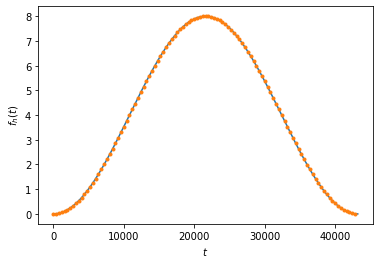

In [4]:
control = {"nx": NX, "dt": DT, "theta": 1.0, "simulation": "tidal_flow"}
params = {"nu": 1e-2}
swe_dgp = ShallowOne(control, params)

# nt_skip = [1, 4, 10, 20, 40, 100]
skip = 100

%matplotlib inline
t_grid = np.linspace(0, t_final, NT)
tidal_bc = swe_dgp.tidal_bc(t_grid)
plt.plot(t_grid, tidal_bc)
plt.plot(t_grid[::skip], tidal_bc[::skip], ".")
plt.ylabel(r"$f_h(t)$")
plt.xlabel(r"$t$")
plt.show()

In [5]:
from multiprocessing import Pool

p = Pool(8)
nus = [[100.], [1e-1], [5e-2], [4e-2], [3e-2], [2.5e-2], [2e-2], [1e-2]]
models = p.starmap(run_tidal_model, nus)


100%|██████████████████████████████████████████████████████████████████| 10800/10800 [00:43<00:00, 250.84it/s]


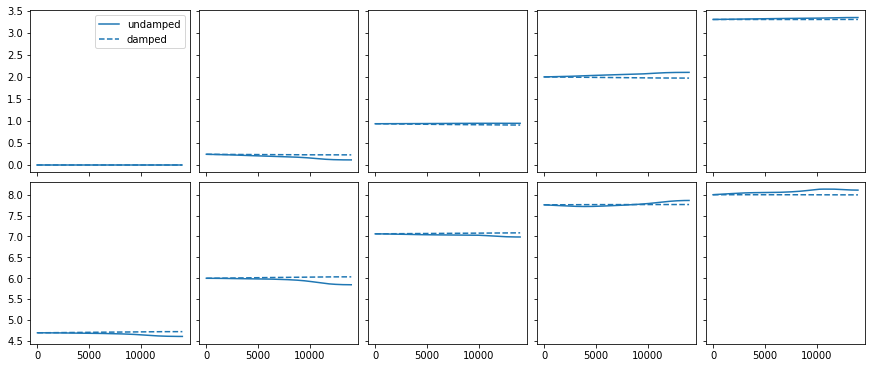

In [6]:
ud, hd, _ = models[0]
u, h, _ = models[-1]

t_idx = np.int64(np.linspace(0, NT // 2, 10))

fig, axs = plt.subplots(2, 5, constrained_layout=True, figsize=(12, 5), sharex=True, sharey="row")
axs = axs.flatten()
for i, j in enumerate(t_idx):
    color = next(axs[i]._get_lines.prop_cycler)['color']
    
    axs[i].plot(swe_dgp.x_coords, h[-j, :], color=color, label="undamped")
    axs[i].plot(swe_dgp.x_coords, hd[-j, :], "--", color=color, label="damped")

axs[0].legend()
plt.show()


[1.0e+02 1.0e-01 5.0e-02 4.0e-02 3.0e-02 2.5e-02 2.0e-02 1.0e-02]


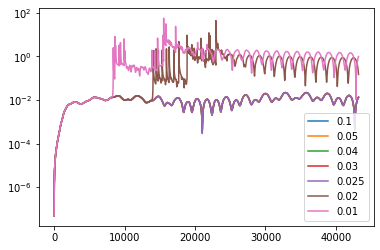

In [12]:
norm = np.linalg.norm
nus = np.array(nus)
nus = nus.flatten() 
print(nus)

dim = 1
ref = models[0][dim]
for i in range(1, len(nus)):
    errors = norm(ref - models[i][dim], axis=1)
    plt.semilogy(t_grid, errors, label=nus[i])
    
plt.legend()
plt.show()

There seems to be some sort of shift in the dynamics when moving into the new regime. For this, we look at the energy of the solution field,

$$
E(t) := \int_\Omega u^2(x, t) \, \mathrm{d} x,
$$

to see what is going on.

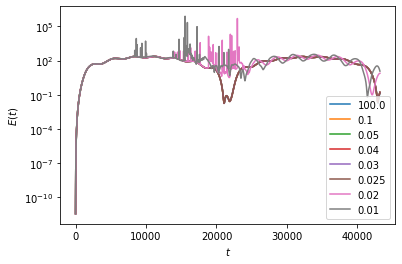

In [8]:
for i in range(len(nus)):
    energy = models[i][2]
    plt.semilogy(t_grid, energy, label=nus[i])
    
plt.xlabel(r'$t$')
plt.ylabel(r'$E(t)$')
plt.legend()
plt.show()


There seems to be some sort of shift in the regime from $0.025 \to 0.02$. Let's look into this further. Consider, as a start, the movement into this regime. We'll run a set of models in this region and evaluate what they look like

In [9]:
nus_refined = [[nu] for nu in np.linspace(0.02, 0.025, 8)]
models_refined = p.starmap(run_tidal_model, nus_refined)


Now we plot the energy of the solutions, defined above, to see what is happening over the simulation

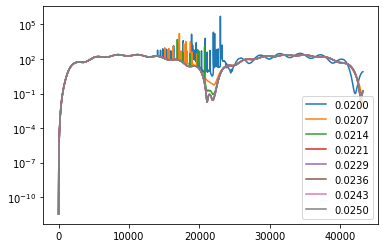

In [10]:
nus_refined = np.array(nus_refined)
nus_refined = nus_refined.flatten()

for i in range(len(nus)):
    energy = models_refined[i][2]
    nu = nus_refined[i]
    plt.semilogy(t_grid, energy, label=f"{nu:.4f}")
    
plt.legend()
plt.show()


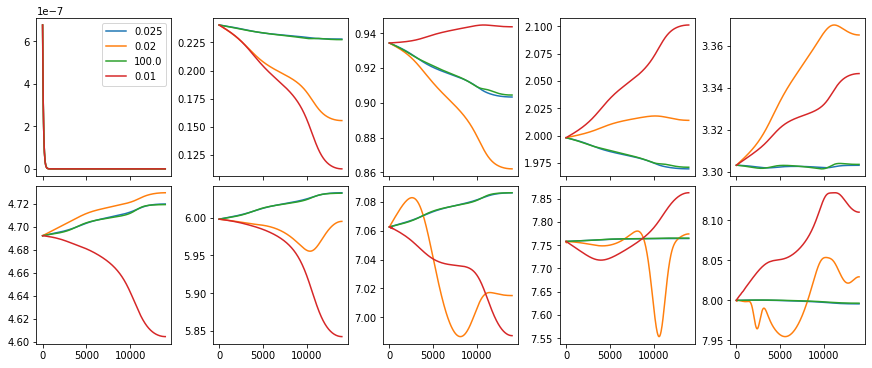

In [11]:
u, h, _ = models_refined[-1]  # no damping at all
ud, hd, _ = models_refined[0]  # small damping
udd, hdd, _ = models[0]  # large damping
u_small, _, _ = models[-1]  # smallest damping

t_idx = np.int64(np.linspace(0, NT // 2, 10))
fig, axs = plt.subplots(2, 5, constrained_layout=True, 
                        figsize=(12, 5), sharex=True)
axs = axs.flatten()
for i, j in enumerate(t_idx):
    axs[i].plot(swe_dgp.x_coords, u[-j, :], label=nus_refined[-1])
    axs[i].plot(swe_dgp.x_coords, ud[-j, :], label=nus_refined[0])
    axs[i].plot(swe_dgp.x_coords, udd[-j, :], label=nus[0])
    axs[i].plot(swe_dgp.x_coords, u_small[-j, :], label=nus[-1])

axs[0].legend()
plt.show()
